# Data Science Case Study – Bay Area Airbnb


The business problem I want to solve is:

**How do we create a price-suggestion model for new Airbnb hosts?**

The scope of this case study is to create an MVP model and outline possible improvement opportunities.

# Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns

#sklearn
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import fetch_openml
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# to make this notebook's output stable across runs
np.random.seed(42)

# Load Data

In [2]:
AIRBNB_PATH = os.path.join("datasets", "Airbnb")

def load_data(filename, airbnb_path=AIRBNB_PATH):
    csv_path = os.path.join(airbnb_path, filename)
    return pd.read_csv(csv_path)

In [3]:
df_listing = load_data("Airbnb_Listings.csv")
df_neighb = load_data("neighbourhoods.csv")
df_reviews = load_data("reviews.csv")

# Step 1 – Data Exploration

In [4]:
# show counts and data type
df_neighb.info(verbose = True, show_counts= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   neighbourhood_group  0 non-null      float64
 1   neighbourhood        16 non-null     object 
dtypes: float64(1), object(1)
memory usage: 384.0+ bytes


The column neighbourgoood_group is made up of null values. Also, the number of entries are less than those in the 'listing' and 'reviews' datasets.

In [5]:
# show counts and data type
df_reviews.info(verbose = True, show_counts= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212513 entries, 0 to 212512
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   listing_id  212513 non-null  int64 
 1   date        212513 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.2+ MB


The number of entries are larger than others in other datasetes.

In [6]:
# show counts and data type
df_listing.info(verbose = True, show_counts= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7221 entries, 0 to 7220
Data columns (total 106 columns):
 #    Column                                        Non-Null Count  Dtype  
---   ------                                        --------------  -----  
 0    id                                            7221 non-null   int64  
 1    listing_url                                   7221 non-null   object 
 2    scrape_id                                     7221 non-null   int64  
 3    last_scraped                                  7221 non-null   object 
 4    name                                          7220 non-null   object 
 5    summary                                       6922 non-null   object 
 6    space                                         5514 non-null   object 
 7    description                                   6983 non-null   object 
 8    experiences_offered                           7221 non-null   object 
 9    neighborhood_overview                         4544

There are 7221 instances in the dataset, which is a small dataset. We noticed that there are a couple of empty columns and a few others that contains null-values. Also, some data types are not adequate for analysis; for example, prices and boolean values are stored as objects. Moving forwarding, we will used the 'listing' data for our analysis because it is the most comprehensive of the three data.

In [7]:
# print first 5 rows
df_listing.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,4952,https://www.airbnb.com/rooms/4952,20200530151957,2020-05-30,Butterfly Inn - Graceful Living !,Lovely garden setting in a serene and art-fill...,Very comfortable Queen bed and small desk in b...,Lovely garden setting in a serene and art-fill...,none,"Located in Professorville, Palo Alto, one of t...",...,f,f,moderate,f,f,5,0,5,0,0.57
1,11464,https://www.airbnb.com/rooms/11464,20200530151957,2020-05-31,Deluxe Private Studio-custom int.,Custom built Studio with exquisite design. Rea...,Description A favorite for international corpo...,Custom built Studio with exquisite design. Rea...,none,10 min. to Lucky's and Starbucks at El Camino ...,...,f,f,moderate,f,t,12,12,0,0,0.08
2,17884,https://www.airbnb.com/rooms/17884,20200530151957,2020-05-31,Silicon Valley Suite,"A guest suite for one or two, in a house in a ...",This is a private suite at the rear of a house...,"A guest suite for one or two, in a house in a ...",none,"This is a very quiet family neighborhood, but ...",...,f,f,strict_14_with_grace_period,f,f,2,2,0,0,0.11
3,21373,https://www.airbnb.com/rooms/21373,20200530151957,2020-05-30,Bonsai Garden Inn in Professorville,Room in gracious home with beautiful garden. ...,"Bright, garden-facing room in beautiful home. ...",Room in gracious home with beautiful garden. ...,none,This room is in an ultra convenient location i...,...,f,f,moderate,f,f,5,0,5,0,2.17
4,37512,https://www.airbnb.com/rooms/37512,20200530151957,2020-05-31,Private room - Parking 3 carport,We live in a safe community close to public tr...,I have a really nice room in a quiet neighborh...,We live in a safe community close to public tr...,none,Our community is a safe environment and at nig...,...,f,f,moderate,t,t,2,0,2,0,1.53


When we looked at the first 5 rows of the data, we noticed that some of the entries include urls and descriptions that are not necessary for our analysis.

In [8]:
#Explore attributes that contains host information
host_col_list = ['host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified']
host_info = df_listing[host_col_list]
host_info.head()

,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified
0,https://www.airbnb.com/users/show/7054,Mei Lin,2009-01-24,"Palo Alto, California, United States","I have lived and worked in Asia, Europe, Austr...",within an hour,100%,98%,t,https://a0.muscache.com/im/users/7054/profile_...,https://a0.muscache.com/im/users/7054/profile_...,Palo Alto,5.0,5.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f
1,https://www.airbnb.com/users/show/42458,Emey,2009-09-30,"Mountain View, California, United States",I pride myself on attention to details and cus...,within an hour,100%,90%,f,https://a0.muscache.com/im/users/42458/profile...,https://a0.muscache.com/im/users/42458/profile...,Santa Clara,13.0,13.0,"['email', 'phone', 'reviews']",t,f
2,https://www.airbnb.com/users/show/69023,Janet,2010-01-08,"Lynn Haven, Florida, United States","I am a software engineer, recently retired fro...",within a day,100%,50%,f,https://a0.muscache.com/im/users/69023/profile...,https://a0.muscache.com/im/users/69023/profile...,Palo Alto,2.0,2.0,"['email', 'phone', 'reviews', 'kba']",t,t
3,https://www.airbnb.com/users/show/7054,Mei Lin,2009-01-24,"Palo Alto, California, United States","I have lived and worked in Asia, Europe, Austr...",within an hour,100%,98%,t,https://a0.muscache.com/im/users/7054/profile_...,https://a0.muscache.com/im/users/7054/profile_...,Palo Alto,5.0,5.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f
4,https://www.airbnb.com/users/show/161741,Maria,2010-07-09,"San Jose, California, United States",I am in a committed relationship with my live...,within a few hours,100%,100%,t,https://a0.muscache.com/im/users/161741/profil...,https://a0.muscache.com/im/users/161741/profil...,South San Jose,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'man...",t,t


We observed separately a few columns that include some information about the host. In addition to our previous discoveries, we noticed that percentages were stored as objects instead of float values. Also, some values in *host_response_time* column were repetitive, which means that it is probably a categotical attribute. Furthermore, the values for *host_listings_count* and *host_total_listings_count* columns appear to be the same; hence, it would be helpful to drop one of the columns.

In [9]:
#check for the number of categories and number of listings that belong to them
host_info['host_response_time'].value_counts()

within an hour        3993
within a few hours     862
within a day           411
a few days or more     148
Name: host_response_time, dtype: int64

In [10]:
#Explore attributes that contains price information
price_col_list= ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee']
price_info = df_listing[price_col_list]
price_info.head()

,price,weekly_price,monthly_price,security_deposit,cleaning_fee
0,$90.00,$440.00,"$1,428.00",$0.00,$35.00
1,$85.00,NaN,"$2,100.00",$700.00,$250.00
2,$65.00,"$1,400.00","$2,800.00","$1,000.00",NaN
3,$99.00,$600.00,"$2,000.00",$0.00,$35.00
4,$52.00,$393.00,"$1,386.00",NaN,NaN


We separetely observed a few columns that contains various price information. We noticed the values were stored as an object instead of float values. Additional there are some missing value that we need to take care of later.

In [11]:
#Explore attributes that contains review information
review_col_list = ['number_of_reviews', 'number_of_reviews_ltm', 'first_review', 'last_review','review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin','review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']
review_info = df_listing[review_col_list]
review_info.head()

,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,75,0,2009-08-02,2019-01-12,96.0,10.0,10.0,10.0,10.0,10.0,10.0,0.57
1,6,1,2014-06-15,2019-10-11,87.0,10.0,10.0,10.0,9.0,9.0,9.0,0.08
2,2,0,2018-11-20,2019-04-27,90.0,8.0,10.0,10.0,10.0,10.0,10.0,0.11
3,264,39,2010-05-28,2020-03-14,97.0,10.0,10.0,10.0,10.0,10.0,10.0,2.17
4,183,0,2010-08-01,2017-03-14,94.0,9.0,10.0,10.0,10.0,9.0,9.0,1.53


We separately observed attributes that contains various information about the review of the listings. We observed that number of reviews receieved for each listings are different.

In [12]:
# check for the summary of the numerical attributes
review_info.describe()

,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
count,7221.000000,7221.000000,5854.000000,5852.000000,5852.000000,5851.000000,5852.000000,5851.000000,5851.000000,5912.000000
mean,29.853760,9.369201,95.245473,9.723855,9.572454,9.815074,9.793233,9.796103,9.527773,1.357124
std,51.488761,15.188236,7.734005,0.741816,0.848685,0.641301,0.691503,0.583498,0.833306,1.530782
min,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.010000
25%,1.000000,0.000000,94.000000,10.000000,9.000000,10.000000,10.000000,10.000000,9.000000,0.320000
50%,10.000000,3.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.830000
75%,35.000000,12.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.810000
max,488.000000,154.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,13.120000


While the minimum *number_of_reviews* recieved for the listings is *'0'*, the mininum *review_scores_value* is *'2'*. Ideally, if no review was recieved for a listing, the review score value for the listing should not exist. Probably this explains why the count for *number_of_reviews* is *'7221'* and the count for *'review_scores_value'* is *'5851'*. Recall, *'7221'* is the total number of entries in the data.

In [13]:
#Explore attributes that contains host listing count information
count_col_list =  ['calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms']  
count_info = df_listing[count_col_list]
count_info.head()

,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,5,0,5,0
1,12,12,0,0
2,2,2,0,0
3,5,0,5,0
4,2,0,2,0


In [14]:
# check for the summary of the numerical attributes
count_info.describe()

,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
count,7221.000000,7221.000000,7221.000000,7221.000000
mean,32.048608,28.216729,2.775793,1.029359
std,95.159193,95.714488,6.810433,5.741521
min,1.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000
50%,3.000000,1.000000,1.000000,0.000000
75%,8.000000,2.000000,3.000000,0.000000
max,411.000000,411.000000,62.000000,48.000000


We separetely observed a few columns that contains host listings count informatons and we obeserved that there are no null values. *calculated_host_listings_count* column is the sum of *calculated_host_listings_count_entire_homes*, *calculated_host_listings_count_private_rooms*, and *calculated_host_listings_count_shared_rooms* columns.

In [15]:
#Explore attributes that contains number of nights
nights_col_list = ['minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm']
nights_info = df_listing[nights_col_list]
nights_info.head()

,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm
0,2,365,2,2,365,365,2.0,365.0
1,14,365,14,14,365,365,14.0,365.0
2,30,180,30,30,180,180,30.0,180.0
3,2,730,2,2,730,730,2.0,730.0
4,1,7,1,1,7,7,1.0,7.0


In [16]:
# check for the summary of the numerical attributes
nights_info.describe()

,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm
count,7221.000000,7.221000e+03,7221.000000,7221.000000,7.221000e+03,7.221000e+03,7221.000000,7.221000e+03
mean,9.756959,2.980880e+05,9.142916,14.247888,2.982325e+05,1.785205e+06,13.631505,1.538945e+06
std,34.689846,2.527150e+07,35.027086,63.358607,2.527150e+07,6.188084e+07,61.691820,5.347742e+07
min,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00
25%,1.000000,6.000000e+01,1.000000,1.000000,3.650000e+02,3.650000e+02,1.000000,3.650000e+02
50%,2.000000,1.125000e+03,2.000000,2.000000,1.125000e+03,1.125000e+03,2.000000,1.125000e+03
75%,7.000000,1.125000e+03,5.000000,7.000000,1.125000e+03,1.125000e+03,7.000000,1.125000e+03
max,1125.000000,2.147484e+09,1125.000000,1125.000000,2.147484e+09,2.147484e+09,1125.000000,2.147484e+09


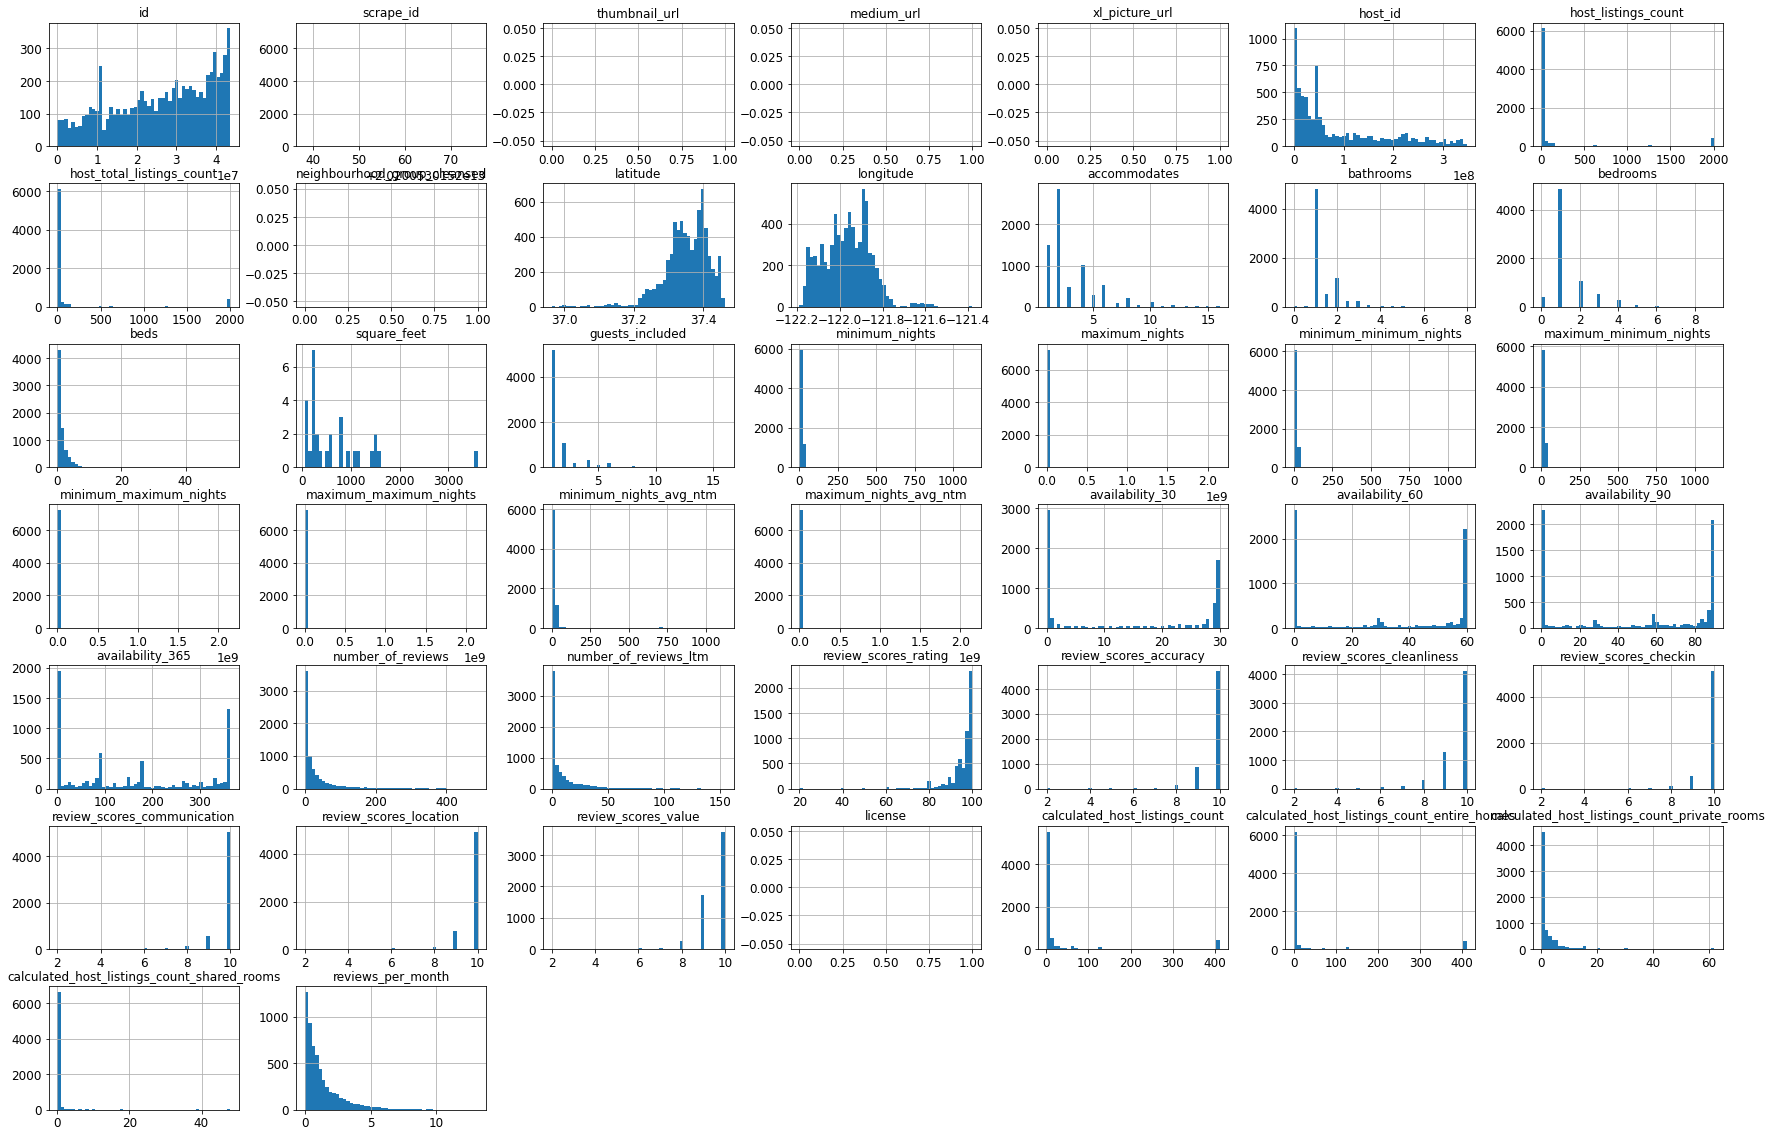

In [17]:
# Explore the data distribution 
# histogram for each numeric variable
%matplotlib inline
df_listing.hist(bins=50, figsize=(30,20))
plt.show()

Many histograms are tail heavy which may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions. Additionally, there are no histograms for some of the features due to the null values or type data.

# Data Preparation/Cleaning

In [18]:
#define columns we are no longer need because they are duplicates, empty, and unnecessary
drop_list = ['listing_url', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_name', 'host_verifications', 'host_url', 'host_about', 
             'host_thumbnail_url', 'host_since', 'host_location', 'host_picture_url', 'host_has_profile_pic', 'neighbourhood_group_cleansed',
             'license', 'weekly_price', 'square_feet', 'monthly_price', 'security_deposit', 'cleaning_fee', 'scrape_id', 'last_scraped', 'id',
             'name', 'summary', 'notes', 'description', 'jurisdiction_names','city', 'state', 'zipcode', 'market', 'smart_location',
             'country_code', 'country', 'calendar_updated', 'street', 'calendar_last_scraped', 'neighbourhood_cleansed', 'space', 'transit', 
             'house_rules','access', 'neighborhood_overview', 'experiences_offered', 'interaction', 'amenities', 'first_review', 'last_review',
             'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm',
             'maximum_nights_avg_ntm', 'host_listings_count', 'host_neighbourhood', 'host_response_time', 'require_guest_profile_picture',
             'require_guest_phone_verification', 'host_identity_verified', 'is_location_exact', 'requires_license', 'cancellation_policy',
             'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
             'availability_30', 'availability_60', 'availability_90', 'availability_365', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
             'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'extra_people',
            'reviews_per_month', 'bedrooms','host_response_rate','host_is_superhost', 'host_total_listings_count', 'bathrooms', 'beds',
            'host_acceptance_rate', 'neighbourhood', 'number_of_reviews_ltm']


df_dropped = df_listing.drop(labels = drop_list, axis = 1)

#define columns that need to adjust data type
cols_to_price = ['price']
cols_to_percent = ['host_response_rate', 'host_acceptance_rate']


In [19]:
# change boolean values from 't' or 'f' to boolean type
df_dropped.loc[df_dropped['instant_bookable'] == 't', 'instant_bookable'] = 1
df_dropped.loc[df_dropped['instant_bookable'] == 'f', 'instant_bookable'] = 0

df_dropped.loc[df_dropped['is_business_travel_ready'] == 't', 'is_business_travel_ready'] = 1
df_dropped.loc[df_dropped['is_business_travel_ready'] == 'f', 'is_business_travel_ready'] = 0

df_dropped.loc[df_dropped['has_availability'] == 't', 'has_availability'] = 1
df_dropped.loc[df_dropped['has_availability'] == 'f', 'has_availability'] = 0


# change price from the form '$1,200.00' to 1200
df_dropped['price'] = df_dropped['price'].str.replace('$', '', regex=True)

In [20]:
df_dropped.head()

,latitude,longitude,property_type,room_type,accommodates,bed_type,price,guests_included,minimum_nights,maximum_nights,has_availability,number_of_reviews,instant_bookable,is_business_travel_ready,calculated_host_listings_count
0,37.43972,-122.15672,Villa,Private room,2,Real Bed,90.00,1,2,365,1,75,0,0,5
1,37.34342,-121.98829,Apartment,Entire home/apt,1,Real Bed,85.00,1,14,365,1,6,0,0,12
2,37.38612,-122.07357,Guest suite,Entire home/apt,2,Real Bed,65.00,1,30,180,1,2,0,0,2
3,37.44001,-122.15667,Villa,Private room,1,Real Bed,99.00,1,2,730,1,264,0,0,5
4,37.30598,-121.84036,Bungalow,Private room,2,Real Bed,52.00,1,1,7,1,183,0,0,2


In [21]:
# separate the numerical variables from the categorical variables
cat_list = ['property_type', 'room_type', 'bed_type', 'is_business_travel_ready', 'has_availability' ]
num_list = ['latitude','longitude','accommodates', 
            'guests_included', 'minimum_nights', 'maximum_nights', 
            'number_of_reviews', 'instant_bookable',
           'calculated_host_listings_count','price']

In [22]:
# change price values from '90.00' or '1,000' to float type
df_dropped['price'] = df_dropped['price'].str.replace(r'\.', '', regex=True)
df_dropped['price'] = df_dropped['price'].str.replace(r'\,', '', regex=True)

df_dropped['price']= df_dropped['price'].astype(float)

df_dropped['price']= df_dropped['price']/100

df_dropped['price'].head()

0    90.0
1    85.0
2    65.0
3    99.0
4    52.0
Name: price, dtype: float64

# Step 2 – Define the business problem you want to solve

The business problem I want to solve is:

**How do we create a price-suggestion model for new Airbnb hosts?**


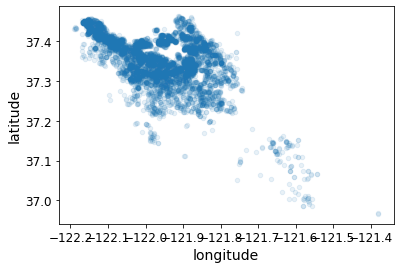

<Figure size 3600x3600 with 0 Axes>

In [23]:
df_dropped.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)
plt.figure(figsize=(50,50))
plt.show()

Visualizing the geographical data shows the highly dense areas. This means that more Airbnb listings are located in these areas.

<AxesSubplot:>

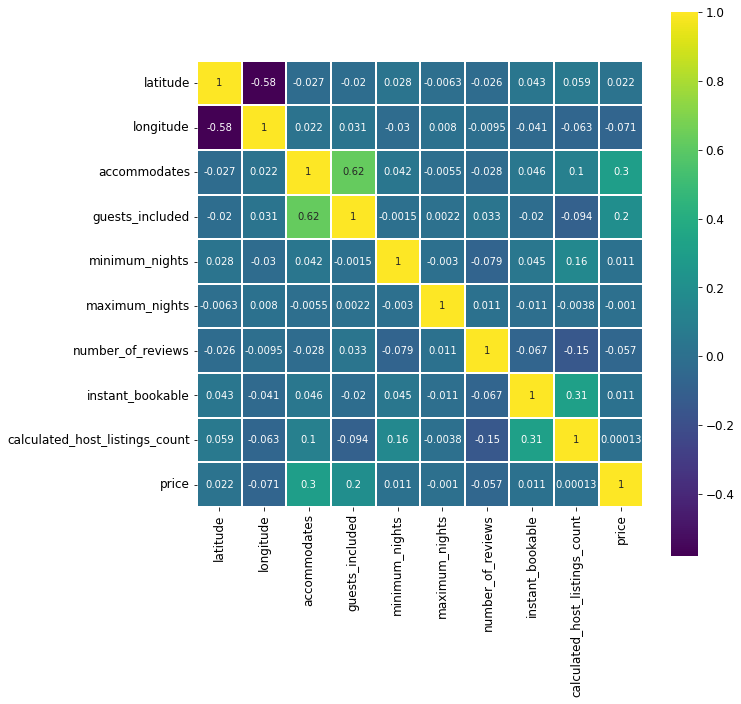

In [24]:
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
sns.heatmap(df_dropped[num_list].astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, annot=True)

This heat map aims to show how colerrated prices of listing are with other features in the dataset. Price is more positively colerrated with number of guest included and number of guests listings accomodates. However, number of guests listings accomodates is most positively colerrated with guest included in the listings.

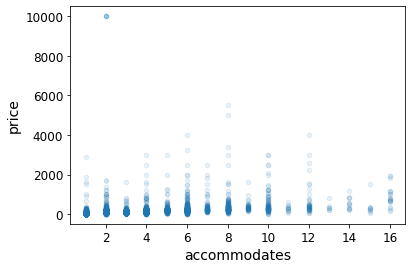

In [25]:
df_dropped.plot(kind ='scatter', x = 'accommodates', y =  'price', alpha =0.1)

plt.show()

Although positively colerrated, the colerration between price and the number of guest a listing can acommodate is not strong.

# Step 3 – Develop a prototype model as an MVP solution to the problem you defined

In [26]:
#Using numeric data from the dataset
df = df_dropped[num_list]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7221 entries, 0 to 7220
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        7221 non-null   float64
 1   longitude                       7221 non-null   float64
 2   accommodates                    7221 non-null   int64  
 3   guests_included                 7221 non-null   int64  
 4   minimum_nights                  7221 non-null   int64  
 5   maximum_nights                  7221 non-null   int64  
 6   number_of_reviews               7221 non-null   int64  
 7   instant_bookable                7221 non-null   object 
 8   calculated_host_listings_count  7221 non-null   int64  
 9   price                           7221 non-null   float64
dtypes: float64(3), int64(6), object(1)
memory usage: 564.3+ KB


In [27]:
# define a function to split dataset
def split_train_test(data, test_ratio):
 shuffled_indices = np.random.permutation(len(data))
 test_set_size = int(len(data) * test_ratio)
 test_indices = shuffled_indices[:test_set_size]
 train_indices = shuffled_indices[test_set_size:]
 return data.iloc[train_indices], data.iloc[test_indices]

In [28]:
train_set, test_set = split_train_test(df, 0.2)

In [29]:
len(train_set)

5777

In [30]:
len(test_set)

1444

In [31]:
# set predictors
train_X = train_set.drop('price', axis=1)
test_X = test_set.drop('price', axis=1)

# set target
train_Y = train_set['price'].copy()
test_Y = test_set['price'].copy()

**Linear Regression Model**

In [32]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_X, train_Y)

LinearRegression()

*Performance Evaluation on Training set*

In [33]:
# calculate RMSE

from sklearn.metrics import mean_squared_error

# Predict
listings_predictions = lin_reg.predict(train_X)

# MSE
lin_mse = mean_squared_error(train_Y, listings_predictions)

# RMSE
lin_rmse = np.sqrt(lin_mse)
lin_rmse

331.7280692419103

This shows that our linear regression model has predition error of $331, which means the model is underfitting the training set. That is, the model is not able to learn the underlying patterns in the data.

*Performance Evaluation on Test set*

In [34]:
# calculate RMSE

from sklearn.metrics import mean_squared_error

# Predict
listings_predictions = lin_reg.predict(test_X)

# MSE
lin_mse = mean_squared_error(test_Y, listings_predictions)

# RMSE
lin_rmse = np.sqrt(lin_mse)
lin_rmse

342.4392286029705

This shows that our linear regression model has predition error of $342, which means the model is also underfitting both the training and test sets.  Some possible reasons might be that the data model is too simple or the data is set is too small or noisy.

**Decision Tree Algorithm**

Let’s train a DecisionTreeRegressor. This is a powerful model, capable of finding complex nonlinear relationships in the data


In [35]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()

# train
tree_reg.fit(train_X, train_Y)

DecisionTreeRegressor()

*Performance Evaluation on Training set*

In [36]:
# Predict
listings_predictions = tree_reg.predict(train_X)

# MSE
tree_reg = mean_squared_error(train_Y, listings_predictions)

# RMSE
tree_reg = np.sqrt(tree_reg)
tree_reg

0.30658346692450467

**This shows that our decission tree model has predition error of about $0.31, which means this is a great price-suggestion model for new Airbnb hosts.**

# Improvement Opportunities

To be sure the decision tree model is not overfitting the data, we could explore better evaluation methods using cross-validation and explore other machine learning algorithms such as random forest, support vector machine, and ensemble and possible neural networks. The goal would be to shortlist a few promising models before spending time tweaking hyperparameters.